# 사용할 라이브러리 및 Cuda 설정

In [2]:
# 사용할 라이브러리 및 Cuda 설정

import os
import glob
import json
import time
import random
import numpy as np
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader, Subset
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    TrainingArguments,
    Trainer,
    TrainerCallback
)
import evaluate

print("라이브러리 임포트 완료")

import torch
print(torch.cuda.is_available())  # True여야 정상
print(torch.version.cuda)  # CUDA 버전 확인
print(torch.backends.cudnn.version())  # cuDNN 버전 확인

import torchaudio
print("torch version:", torch.__version__)
print("torchaudio version:", torchaudio.__version__)


# # device 설정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print("Using device:", device)



ImportError: /home/kookmin/.local/lib/python3.10/site-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12: undefined symbol: __nvJitLinkComplete_12_4, version libnvJitLink.so.12

# hyper parameter & 저장된 데이터 경로 & 저장 경로


In [ ]:
# hyper parameter & 저장된 데이터 경로 & 저장 경로


# 데이터 경로
DATA_DIR_TRAIN = '/data/seungmin/training'
DATA_DIR_VAL = '/data/seungmin/validation'

# 저장 경로
MODEL_SAVE_DIR = '/data/seungmin/model'
# CHECKPOINT_DIR = os.path.join(MODEL_SAVE_DIR, 'checkpoints')
# if not os.path.exists(CHECKPOINT_DIR):
#     os.makedirs(CHECKPOINT_DIR)

# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 하이퍼파라미터 설정 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 
BATCH_SIZE = 8 # 8로 했더니 cuda out of mem 떴음
GRAD_ACCUMULATION_STEPS = 8         # 2로 했더니 cuda out of mem떴음
LEARNING_RATE = 1e-5
NUM_EPOCHS = 2
WARMUP_RATIO = 0.1
MAX_DURATION_SEC = 10  # 최대 입력 길이 30초
SAMPLE_RATE = 16000

# 학습 데이터에서 매 에포크마다 일정 비율(예: 1%) 샘플링 (재현성을 위해 seed 고정)
SAMPLE_FRACTION = 0.01
RANDOM_SEED = 2025

# # 체크포인트 및 early stopping을 위한 patience 변수
# PATIENCE = 3

print("설정 완료")


설정 완료


# 데이터 파일 리스트 생성 (wav와 JSON 매칭)

In [1]:
# 데이터 파일 리스트 생성 (wav와 JSON 매칭)

def build_file_list(data_dir):
    file_list = []
    audio_pattern = os.path.join(data_dir, 'source', 'eng', '*', '*', '*.wav')
    audio_files = glob.glob(audio_pattern)
    
    for audio_path in audio_files:
        json_path = audio_path.replace(os.path.join('source', 'eng'), os.path.join('labels', 'eng')).replace('.wav', '.json')
        if os.path.exists(json_path):
            try:
                with open(json_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                text = data["06_transcription"]["1_text"]
                file_list.append({
                    "audio_path": audio_path,
                    "json_path": json_path,
                    "text": text
                })
            except Exception as e:
                print(f"파일 {json_path} 로드 중 오류 발생: {e}")
        else:
            print(f"JSON 파일이 존재하지 않음: {json_path}")
    return file_list

# 훈련 및 검증 파일 리스트 생성
train_files = build_file_list(DATA_DIR_TRAIN)
val_files = build_file_list(DATA_DIR_VAL)

print("예시 훈련 파일:", train_files[0])
print(f"훈련 파일 수: {len(train_files)}")
print(f"검증 파일 수: {len(val_files)}")


NameError: name 'DATA_DIR_TRAIN' is not defined

# 오디오 로딩 및 전처리(custom dataset class 정의)


In [4]:

import torchaudio
import soundfile as sf

class SpeechDataset(Dataset):
    def __init__(self, file_list, processor, sample_rate=SAMPLE_RATE, max_duration=MAX_DURATION_SEC):
        """
        file_list: build_file_list()로 생성한 파일 리스트
        processor: Wav2Vec2Processor 객체
        sample_rate: 목표 샘플링 레이트
        max_duration: 최대 길이(초)
        """
        valid_list = []
        for item in file_list:
            audio_path = item['audio_path']
            loaded = False
            try:
                _waveform, sr = torchaudio.load(audio_path, format="wav")
                loaded = True
            except Exception as e:
                try:
                    waveform, sr = sf.read(audio_path)
                    _ = torch.tensor(waveform).float()
                    loaded = True
                    print(f"파일 {audio_path}는 soundfile로 로드 가능합니다.")
                except Exception as e2:
                    print(f"파일 {audio_path} 필터링됨: torchaudio 실패({e}), soundfile 실패({e2})")
                    continue
            valid_list.append(item)
        self.file_list = valid_list
        self.processor = processor
        self.sample_rate = sample_rate
        self.max_length = sample_rate * max_duration
        print(f"SpeechDataset 생성 완료: {len(self.file_list)}개의 유효한 샘플 포함.")

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        item = self.file_list[idx]
        audio_path = item['audio_path']
        loaded = False
        try:
            speech_tensor, sr = torchaudio.load(audio_path, format="wav")
            loaded = True
        except Exception as e:
            print(f"__getitem__: torchaudio.load() 실패: {audio_path} ({e})")
        
        if not loaded:
            try:
                waveform, sr = sf.read(audio_path)
                speech_tensor = torch.tensor(waveform).float()
                if speech_tensor.dim() == 1:
                    speech_tensor = speech_tensor.unsqueeze(0)
                loaded = True
                print(f"__getitem__: soundfile 로드 성공: {audio_path}")
            
            except Exception as e:
                print(f"__getitem__: 파일 로드 실패: {audio_path} ({e})")
                dummy_audio = np.zeros(self.max_length, dtype=np.float32)
                return {"input_values": dummy_audio, "labels": ""}
        
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.sample_rate)
            speech_tensor = resampler(speech_tensor)
        speech_array = speech_tensor.squeeze().numpy()
        
        if len(speech_array) > self.max_length:
            speech_array = speech_array[:self.max_length]
        text = item['text']
        return {"input_values": speech_array, "labels": text}

print("SpeechDataset 클래스 정의 완료")


SpeechDataset 클래스 정의 완료


# model, processor 로딩

In [16]:
# model, processor 로딩

processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
model.gradient_checkpointing_enable()  # 메모리 최적화를 위해 체크포인트 사용

print("모델 및 프로세서 로드 완료")



모델 및 프로세서 로드 완료


# 데이터셋 인스턴스 생성

In [17]:
# 데이터셋 인스턴스 생성

train_dataset = SpeechDataset(train_files, processor, sample_rate=SAMPLE_RATE, max_duration=MAX_DURATION_SEC)
val_dataset = SpeechDataset(val_files, processor, sample_rate=SAMPLE_RATE, max_duration=MAX_DURATION_SEC)

print(train_dataset[0])
print(f"훈련 데이터셋 샘플 수[wav&json]: {len(train_dataset)}")
print(f"검증 데이터셋 샘플 수[wav&json]: {len(val_dataset)}")


# ------------------------------ 학습 데이터 샘플링 --------------------------
# 35만개정도 되어서 에폭수를 늘릴 수 없음 --> 에퐄단위에서 학습 경향성 파악하기 어려움. 전체 데이터셋 중 일부만을 사용하자. random seed로 고정해놨기에 에퐄수만 늘리면 모든 데이터셋 학습 가능함
num_train_samples = int(len(train_dataset) * SAMPLE_FRACTION)
indices = np.random.RandomState(RANDOM_SEED).choice(len(train_dataset), num_train_samples, replace=False)
train_dataset = Subset(train_dataset, indices)

# ------------------------------ validation 데이터 샘플링 --------------------------
# 4만개정도 되어서 에폭수를 늘릴 수 없음 --> 에퐄단위에서 학습 경향성 파악하기 어려움. 전체 데이터셋 중 일부만을 사용하자. random seed로 고정해놨기에 에퐄수만 늘리면 모든 데이터셋 학습 가능함
num_val_samples = int(len(val_dataset) * SAMPLE_FRACTION)
indices = np.random.RandomState(RANDOM_SEED).choice(len(val_dataset), num_val_samples, replace=False)
val_dataset = Subset(val_dataset, indices)

print('-------------------------------------------------')
print(f"샘플링한 validation 데이터셋 샘플 수[wav&json]: {len(val_dataset)}")
print(f"샘플링한 훈련 데이터셋 샘플 수[wav&json]: {len(train_dataset)}")


SpeechDataset 생성 완료: 357212개의 유효한 샘플 포함.
SpeechDataset 생성 완료: 40387개의 유효한 샘플 포함.
{'input_values': array([-0.00125122,  0.00015259, -0.00076294, ...,  0.0161438 ,
       -0.01742554, -0.09042358], shape=(160000,), dtype=float32), 'labels': '낮고 그다음에 프롭의 추진력이 좀 세야 되 강해야 되기 때문에 코드가 긴 (sf)/(에스에프) 형상 이런 형상을 기준으로 선 선택하는게 좀 더 좋고 저중량 같은 경우에는 코드가 좀 짧은 이런 형상을 선택하는 것이 조금 더 좋을 수 있다 볼 수 있는 거예요.'}
훈련 데이터셋 샘플 수[wav&json]: 357212
검증 데이터셋 샘플 수[wav&json]: 40387
-------------------------------------------------
샘플링한 validation 데이터셋 샘플 수[wav&json]: 403
샘플링한 훈련 데이터셋 샘플 수[wav&json]: 3572


In [7]:
# 최적의 num_workers 찾기
import time
from torch.utils.data import DataLoader

# # DataLoader 최적 num_workers 찾기
# def find_optimal_num_workers(dataset, batch_size=BATCH_SIZE, num_workers_list=[0, 4, 8, 12, 16]):
#     import time
#     results = {}
#     for num_workers in num_workers_list:
#         loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
#         start_time = time.time()
#         # 5 배치만 로딩 테스트
#         for _ in range(5):
#             _ = next(iter(loader))
#         elapsed_time = time.time() - start_time
#         results[num_workers] = elapsed_time
#         print(f"num_workers={num_workers}: {elapsed_time:.4f} sec")
#     best_workers = min(results, key=results.get)
#     print(f"✅ 최적 num_workers 값: {best_workers}")
#     return best_workers

optimal_workers = 2
print(f"DataLoader에 적용할 num_workers: {optimal_workers}")




DataLoader에 적용할 num_workers: 2


# only 디버깅용

In [8]:
# # only 디버깅용

# # 빈 샘플이 있는지 확인
# empty_samples = [i for i, sample in enumerate(train_dataset) if len(sample["input_values"]) == 0 or sample["labels"] == ""]
# print(f"비어 있는 샘플 개수: {len(empty_samples)}")


# 데이터 collator 정의 (dynamic padding 포함)

In [9]:
# 데이터 collator 정의 (dynamic padding 포함)

def data_collator(features):
    if isinstance(features, list):
        if features and isinstance(features[0], dict):
            input_values = [f["input_values"] for f in features]
            labels = [f["labels"] for f in features]
        else:
            raise ValueError("리스트 내 요소가 dict 형태가 아닙니다.")
    elif isinstance(features, dict):
        input_values = features.get("input_values", [])
        labels = features.get("labels", [])
    else:
        raise ValueError("배치의 형식이 올바르지 않습니다.")
    
    # processor를 사용해 동적 패딩 수행
    batch = processor(input_values, text=labels, sampling_rate=SAMPLE_RATE, padding=True, return_tensors="pt")
    return batch


# Training aruments 설정

In [10]:
# Training arguments 설정정

# 하이퍼파라미터 설정은 위에서 하기 

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_DIR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=GRAD_ACCUMULATION_STEPS,
    eval_strategy="epoch",
    save_strategy="epoch", # 매 epoch가 끝날 때마다 자동 저장
    learning_rate=LEARNING_RATE,
    num_train_epochs=NUM_EPOCHS,
    warmup_ratio=WARMUP_RATIO,
    fp16=True,
    logging_steps=100,
    save_total_limit=2, # 저장 개수 제한 - 메모리 용량 초과 우려
    load_best_model_at_end=True, # 학습이 모두 끝나면 가장 성능이 좋은 체크포인트(베스트 모델)를 자동으로 불러와서 model에 로드
    dataloader_num_workers=optimal_workers  # 최적 num_workers 적용
)

# 평가 지표 함수 (WER 기반)
wer_metric = evaluate.load("wer")
def compute_metrics(pred):
    print("compute_metrics() 호출됨")
    print("pred.predictions:", pred.predictions)
    print("pred.label_ids:", pred.label_ids)
    
    if pred.predictions is None or pred.label_ids is None:
        return {"wer": float("inf")}  # 오류 방지

    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)
    pred_str = processor.batch_decode(pred_ids)
    label_ids = pred.label_ids
    label_str = processor.batch_decode(label_ids, group_tokens=False)
    
    if not pred_str or not label_str:
        return {"wer": float("inf")}  # WER 무한대 처리

    wer = wer_metric.compute(predictions=pred_str, references=label_str)
    return {"wer": wer}

# 전역 변수에 에포크별 로그 저장 (loss 및 WER 기반, 필요에 따라 "정확도"로 변환 가능)
log_history = {
    "train_losses": [],
    "val_losses": [],
    "train_accs": [],
    "val_accs": []
}

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

print("Trainer 생성 완료.")


Trainer 생성 완료.


In [11]:
# # 데이터셋 확인
# for i in range(len(train_dataset)):
#     sample = train_dataset[i]
#     if sample is None:
#         print(f"인덱스 {i}는 유효하지 않습니다.")


# empty_samples = [i for i, sample in enumerate(train_dataset) if not sample["speech"] or not sample["text"]]
# print(f"비어 있는 샘플 개수: {len(empty_samples)}")

sample = train_dataset[0]
print(f"첫 번째 샘플 speech 길이: {len(sample['input_values'])}")
print(f"첫 번째 샘플 text: {sample['labels']}")


첫 번째 샘플 speech 길이: 18391
첫 번째 샘플 text: 다음에 이제 노선 구조입니다.


# Trainer 콜백 정의 – 에포크별 로그 저장 및 체크포인트 저장
## 커스텀 콜백 정의 – 에포크별 로그 저장 및 체크포인트 저장

In [12]:
# 콜백 정의 (Trainer 인스턴스를 직접 주입)

from transformers import TrainerCallback

# 콜백에 Trainer 참조를 저장해두고, on_epoch_end에서 활용
log_history = {
    "train_losses": [],
    "val_losses": [],
    "train_accs": [],
    "val_accs": []
}

class EpochMetricsCallback(TrainerCallback):
    def __init__(self, trainer, log_history):
        super().__init__()
        self.trainer = trainer
        self.log_history = log_history

    def on_epoch_end(self, args, state, control, **kwargs):
        # # 1) 학습 세트 평가
        # train_metrics = self.trainer.evaluate(eval_dataset=self.trainer.train_dataset)
        # # 2) 검증 세트 평가
        # val_metrics   = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)
        
        train_metrics = self.trainer.evaluate(eval_dataset=self.trainer.train_dataset)
        val_metrics   = self.trainer.evaluate(eval_dataset=self.trainer.eval_dataset)

        print("train_metrics:", train_metrics)
        print("val_metrics:", val_metrics)

        
        train_loss = train_metrics.get("eval_loss", float("inf"))  # 기본값 설정
        val_loss   = val_metrics.get("eval_loss", float("inf"))    # 기본값 설정
        train_wer  = train_metrics.get("wer", 1.0)  # 기본 WER을 1.0(100% 오류)로 설정
        val_wer    = val_metrics.get("wer", 1.0)

        train_acc = 100.0 - train_wer * 100 if train_wer is not None else 0.0
        val_acc   = 100.0 - val_wer   * 100 if val_wer   is not None else 0.0

        print(f"\n--- Epoch {state.epoch:.0f} ---")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc(100-WER): {train_acc:.2f}%")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc(100-WER):   {val_acc:.2f}%")

        self.log_history["train_losses"].append(train_loss)
        self.log_history["val_losses"].append(val_loss)
        self.log_history["train_accs"].append(train_acc)
        self.log_history["val_accs"].append(val_acc)

        return control

epoch_callback = EpochMetricsCallback(trainer, log_history)
trainer.add_callback(epoch_callback)

print("EpochMetricsCallback 등록 완료.")

EpochMetricsCallback 등록 완료.


In [ ]:
# cache flushing

torch.cuda.empty_cache()

# Trainer 객체 생성  & 학습 실행

In [18]:
# 학습 실행
train_result = trainer.train(resume_from_checkpoint=False)  # 이전 체크포인트에서 재개하려면 True로 변경
print("파인튜닝 완료")


Epoch,Training Loss,Validation Loss,Wer
0,No log,inf,1.003552
1,1461096.320000,inf,1.003552


compute_metrics() 호출됨
pred.predictions: [[[-13.2734375   -4.015625   -12.0859375  ... -14.625      -15.59375
    23.75      ]
  [-11.9140625   -5.0625     -11.1171875  ... -14.140625   -15.5078125
    23.65625   ]
  [-14.9921875   -4.5039062  -11.5234375  ... -13.203125   -16.953125
    25.734375  ]
  ...
  [ -8.0703125   -4.2578125  -10.2265625  ... -12.3203125  -13.5703125
    17.390625  ]
  [ -8.0703125   -4.2578125  -10.2265625  ... -12.3203125  -13.5703125
    17.390625  ]
  [ -8.0703125   -4.2578125  -10.2265625  ... -12.3203125  -13.5703125
    17.390625  ]]

 [[-12.7734375    2.4804688  -13.046875   ...  -7.4375     -14.3046875
    16.359375  ]
  [-12.3984375    1.8144531  -12.7109375  ...  -7.7265625  -14.828125
    17.375     ]
  [-15.9140625   -3.0234375  -13.8984375  ... -10.8671875  -18.8125
    25.234375  ]
  ...
  [ -9.203125    -0.44873047 -13.5078125  ...  -3.6054688  -16.484375
    13.0546875 ]
  [ -9.203125    -0.44873047 -13.5078125  ...  -3.6054688  -16.484375
    

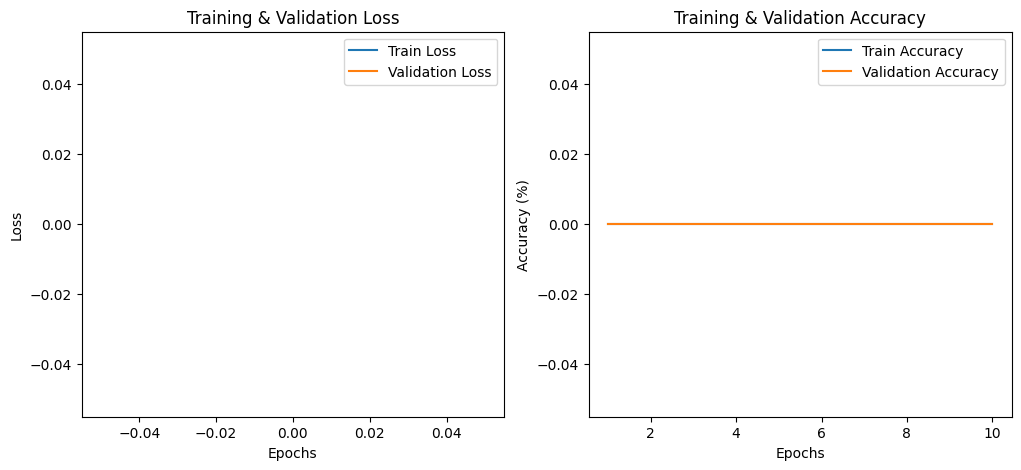

In [ ]:
# 학습 결과 시각화
def plot_results(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training & Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.title('Training & Validation Accuracy')

    plt.show()

plot_results(log_history["train_losses"], log_history["val_losses"],
             log_history["train_accs"], log_history["val_accs"])



# 체크포인트 로드(학습 재개) 로직

## 체크포인트 저장: save_strategy="epoch"와 Trainer.train() 호출 → 자동 생성
## 체크포인트 불러오기: trainer.train(resume_from_checkpoint=True) 또는 경로 지정 → 자동 로드

In [ ]:
# # 마지막 체크포인트(가장 최근)를 자동으로 찾아서 불러옴
# trainer.train(resume_from_checkpoint=True)


# # 특정 체크포인트 지정해서 시작
# ''' 주석 해제하면 됨'''
# # checkpoint_path = "/data/seungmin/model/checkpoint-2000" 
# trainer.train(resume_from_checkpoint=checkpoint_path)